In [1]:
#%%
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

## Embedding层

In [2]:
#%%
x = tf.range(10)
x = tf.random.shuffle(x)
# 创建共10个单词，每个单词用长度为4的向量表示的层
net = layers.Embedding(10, 4)
out = net(x)

In [3]:
print(out.shape)

(10, 4)


## SimpleRNNCell

In [4]:
cell = layers.SimpleRNNCell(3)
cell.build(input_shape=(None,4))
cell.trainable_variables

[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.7576244 ,  0.87684464, -0.18167937],
        [-0.24517381, -0.0435093 , -0.7579328 ],
        [ 0.7295934 ,  0.05551606,  0.0779804 ],
        [ 0.50561786,  0.38797855, -0.09666789]], dtype=float32)>,
 <tf.Variable 'recurrent_kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.36170995, -0.9119809 ,  0.19353722],
        [ 0.8348372 , -0.22443914,  0.50266683],
        [-0.41498524,  0.34339172,  0.84253746]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

### 使用

In [5]:
h0 = [tf.zeros([4, 64])]
x = tf.random.normal([4, 80, 100])
xt = x[:,0,:]
# 构建输入特征f=100,序列长度s=80,状态长度=64的Cell
cell = layers.SimpleRNNCell(64)
out, h1 = cell(xt, h0) # 前向计算
print(out.shape, h1[0].shape)
print(id(out), id(h1[0])) 

(4, 64) (4, 64)
3033784686968 3033784686968


In [9]:
#%%
h = h0
# i=0
# 在序列长度的维度解开输入，得到xt:[b,f]
for xt in tf.unstack(x, axis=1):
    out, h = cell(xt, h) # 前向计算
#     print(i)
#     i=i+1
# 最终输出可以聚合每个时间戳上的输出，也可以只取最后时间戳的输出
out = out

## 多层SimpleRNN

In [10]:
#%%
x = tf.random.normal([4,80,100])
xt = x[:,0,:] # 取第一个时间戳的输入x0
print(xt.shape)
# 构建2个Cell,先cell0,后cell1
cell0 = layers.SimpleRNNCell(64)
cell1 = layers.SimpleRNNCell(64)
h0 = [tf.zeros([4,64])] # cell0的初始状态向量
h1 = [tf.zeros([4,64])] # cell1的初始状态向量

out0, h0 = cell0(xt, h0)
out1, h1 = cell1(out0, h1)

(4, 100)


In [12]:
#%%
for xt in tf.unstack(x, axis=1):
#     print(xt.shape)
    # xtw作为输入，输出为out0
    out0, h0 = cell0(xt, h0)
    # 上一个cell的输出out0作为本cell的输入
    out1, h1 = cell1(out0, h1)

### 第二种

In [17]:
print(x.shape)
# 保存上一层的所有时间戳上面的输出
middle_sequences = []
# 计算第一层的所有时间戳上的输出，并保存
for xt in tf.unstack(x, axis=1):
    out0, h0 = cell0(xt, h0)
    middle_sequences.append(out0)
# 计算第二层的所有时间戳上的输出
# 如果不是末层，需要保存所有时间戳上面的输出
for xt in middle_sequences:
    out1, h1 = cell1(xt, h1)

(4, 80, 100)


## SimpleRNN层

In [18]:
layer = layers.SimpleRNN(64)
x = tf.random.normal([4, 80, 100])
out = layer(x)
out.shape

TensorShape([4, 64])

In [21]:
layer = layers.SimpleRNN(64,return_sequences=True)
out = layer(x) 
out.shape

TensorShape([4, 80, 64])

### 多层

In [14]:
net = keras.Sequential([ # 构建2层RNN网络
# 除最末层外，都需要返回所有时间戳的输出
layers.SimpleRNN(64, return_sequences=True),
layers.SimpleRNN(64),
])
out = net(x)
out.shape

TensorShape([4, 64])

## RNN情感分析实战

In [23]:
import  os
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras
from    tensorflow.keras import layers, losses, optimizers, Sequential

In [24]:
tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

In [42]:
batchsz = 512 # 批量大小
total_words = 10000 # 词汇表大小N_vocab
max_review_len = 80 # 句子最大长度s，大于的句子部分将截断，小于的将填充
embedding_len = 100 # 词向量特征长度f
# 加载IMDB数据集，此处的数据采用数字编码，一个数字代表一个单词
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=total_words)
print(x_train.shape, len(x_train[0]), y_train.shape)
print(x_test.shape, len(x_test[0]), y_test.shape)

(25000,) 218 (25000,)
(25000,) 68 (25000,)


In [26]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [27]:
# 数字编码表
word_index = keras.datasets.imdb.get_word_index()

In [28]:
len(word_index)

88584

In [21]:
# for k,v in word_index.items():
#     print(k,v)
#%%
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
# 翻转编码表
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [22]:
len(word_index)

88588

In [30]:
reverse_word_index[1]

'<START>'

In [30]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [31]:
decode_review(x_train[8])

"<START> just got out and cannot believe what a brilliant documentary this is rarely do you walk out of a movie theater in such awe and <UNK> lately movies have become so over hyped that the thrill of discovering something truly special and unique rarely happens <UNK> <UNK> did this to me when it first came out and this movie is doing to me now i didn't know a thing about this before going into it and what a surprise if you hear the concept you might get the feeling that this is one of those <UNK> movies about an amazing triumph covered with over the top music and trying to have us fully convinced of what a great story it is telling but then not letting us in <UNK> this is not that movie the people tell the story this does such a good job of capturing every moment of their involvement while we enter their world and feel every second with them there is so much beyond the climb that makes everything they go through so much more tense touching the void was also a great doc about mountain 

In [44]:
# x_train:[b, 80]
# x_test: [b, 80]
# 截断和填充句子，使得等长，此处长句子保留句子后面的部分，短句子在前面填充
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_review_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_review_len)
# 构建数据集，打散，批量，并丢掉最后一个不够batchsz的batch
db_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
db_train = db_train.shuffle(1000).batch(batchsz, drop_remainder=True)
db_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
db_test = db_test.batch(batchsz, drop_remainder=True)
print('x_train shape:', x_train.shape, tf.reduce_max(y_train), tf.reduce_min(y_train))
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80) tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)
x_test shape: (25000, 80)


In [33]:
class MyRNN(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyRNN, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.SimpleRNN(units, dropout=0.5, return_sequences=True),
            layers.SimpleRNN(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(32),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

In [34]:
units = 64 # RNN状态向量长度f
epochs = 50 # 训练epochs

model = MyRNN(units)
# 装配
model.compile(optimizer = optimizers.Adam(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [35]:
# 训练和验证
model.fit(db_train, epochs=epochs, validation_data=db_test)

Epoch 1/50
48/48 [==============================] - 7s 144ms/step - loss: 0.7100 - accuracy: 0.5012 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
48/48 [==============================] - 5s 106ms/step - loss: 0.6938 - accuracy: 0.5068 - val_loss: 0.6921 - val_accuracy: 0.5366
Epoch 3/50
48/48 [==============================] - 5s 105ms/step - loss: 0.6858 - accuracy: 0.5490 - val_loss: 0.6220 - val_accuracy: 0.6859
Epoch 4/50
48/48 [==============================] - 5s 105ms/step - loss: 0.5172 - accuracy: 0.7587 - val_loss: 0.3893 - val_accuracy: 0.8270
Epoch 5/50
48/48 [==============================] - 5s 105ms/step - loss: 0.3619 - accuracy: 0.8537 - val_loss: 0.4350 - val_accuracy: 0.8291
Epoch 6/50
48/48 [==============================] - 5s 106ms/step - loss: 0.2958 - accuracy: 0.8867 - val_loss: 0.4873 - val_accuracy: 0.8255
Epoch 7/50
48/48 [==============================] - 5s 107ms/step - loss: 0.2324 - accuracy: 0.9142 - val_loss: 0.4908 - val_accuracy: 0.827

In [36]:
# 测试
model.evaluate(db_test)

48/48 [==============================] - 1s 17ms/step - loss: 1.4069 - accuracy: 0.8151


[1.406923530002435, 0.81514484]

## 梯度弥散和梯度爆炸

In [38]:
W = tf.ones([2,2]) # 任意创建某矩阵
eigenvalues = tf.linalg.eigh(W)[0] # 计算特征值
eigenvalues

<tf.Tensor: id=30927, shape=(2,), dtype=float32, numpy=array([0., 2.], dtype=float32)>

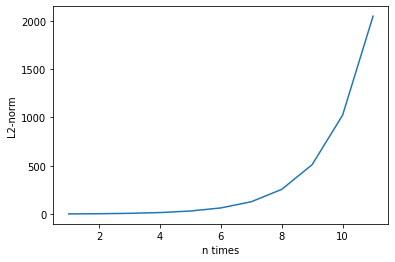

In [39]:
#%%
val = [W]
for i in range(10): # 矩阵相乘n次方
    val.append([val[-1]@W])
# 计算L2范数
norm = list(map(lambda x:tf.norm(x).numpy(),val))
plt.plot(range(1,12),norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')
# plt.savefig('w_n_times_1.svg')
plt.show()

tf.Tensor([0.  0.8], shape=(2,), dtype=float32)


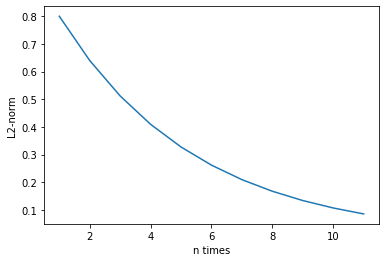

In [40]:
#%%
W = tf.ones([2,2])*0.4 # 任意创建某矩阵
eigenvalues = tf.linalg.eigh(W)[0] # 计算特征值
print(eigenvalues)
val = [W]
for i in range(10):
    val.append([val[-1]@W])
norm = list(map(lambda x:tf.norm(x).numpy(),val))
plt.plot(range(1,12),norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')
# plt.savefig('w_n_times_0.svg')
plt.show()

In [41]:
#%%
a=tf.random.uniform([2,2])
tf.clip_by_value(a,0.4,0.6) # 梯度值裁剪

<tf.Tensor: id=31114, shape=(2, 2), dtype=float32, numpy=
array([[0.4       , 0.59142506],
       [0.6       , 0.6       ]], dtype=float32)>

In [42]:
a=tf.random.uniform([2,2]) * 5
# 按范数方式裁剪
b = tf.clip_by_norm(a, 5)
tf.norm(a),tf.norm(b)

(<tf.Tensor: id=31145, shape=(), dtype=float32, numpy=8.08476>,
 <tf.Tensor: id=31150, shape=(), dtype=float32, numpy=4.9999995>)

In [43]:
w1=tf.random.normal([3,3]) # 创建梯度张量1
w2=tf.random.normal([3,3]) # 创建梯度张量2
# 计算global norm
global_norm=tf.math.sqrt(tf.norm(w1)**2+tf.norm(w2)**2) 
# 根据global norm和max norm=2裁剪
(ww1,ww2),global_norm=tf.clip_by_global_norm([w1,w2],2)
# 计算裁剪后的张量组的global norm
global_norm2 = tf.math.sqrt(tf.norm(ww1)**2+tf.norm(ww2)**2)
print(global_norm, global_norm2)

tf.Tensor(3.2026575, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32)


In [ ]:
with tf.GradientTape() as tape:
    logits = model(x) # 前向传播
    loss = criteon(y, logits) # 误差计算
# 计算梯度值
grads = tape.gradient(loss, model.trainable_variables)
grads, _ = tf.clip_by_global_norm(grads, 25) # 全局梯度裁剪
# 利用裁剪后的梯度张量更新参数
optimizer.apply_gradients(zip(grads, model.trainable_variables))

## LSTMCell

In [44]:
x = tf.random.normal([2,80,100])
xt = x[:,0,:] # 得到一个时间戳的输入
cell = layers.LSTMCell(64) # 创建Cell
# 初始化状态和输出List,[h,c]
state = [tf.zeros([2,64]),tf.zeros([2,64])]
out, state = cell(xt, state) # 前向计算
id(out),id(state[0]),id(state[1])

(1836571435080, 1836571435080, 1836569425456)

In [32]:
net = layers.LSTM(4)
net.build(input_shape=(None,5,3))
net.trainable_variables

[<tf.Variable 'kernel:0' shape=(3, 16) dtype=float32, numpy=
 array([[ 0.11973578,  0.03518277, -0.47716   ,  0.52556413, -0.0078398 ,
          0.20304042, -0.3032422 ,  0.55840546,  0.15683568,  0.510279  ,
          0.44711846, -0.21903077,  0.12290078,  0.54183084, -0.4215247 ,
         -0.00953424],
        [ 0.42180926,  0.3431865 , -0.06528306, -0.02494115,  0.0208171 ,
          0.1292929 , -0.09635094, -0.4720353 ,  0.12636602, -0.09750342,
          0.3340153 , -0.15362537,  0.40015268,  0.29057842, -0.06269979,
          0.08761692],
        [ 0.5431548 , -0.35553515, -0.47243896,  0.5494618 ,  0.5150735 ,
          0.3364609 ,  0.12205857, -0.37847757,  0.4122151 , -0.21188161,
          0.22288239,  0.54009086,  0.4181701 ,  0.3864168 ,  0.37283474,
          0.02733451]], dtype=float32)>,
 <tf.Variable 'recurrent_kernel:0' shape=(4, 16) dtype=float32, numpy=
 array([[-0.24952722, -0.10625644, -0.09382117, -0.10740637, -0.00578529,
         -0.21587995, -0.28717503, -0.378

In [46]:
net = layers.GRU(4)
net.build(input_shape=(None,5,3))
net.trainable_variables

[<tf.Variable 'kernel:0' shape=(3, 12) dtype=float32, numpy=
 array([[ 0.40103143, -0.46793008,  0.3814847 ,  0.51146156,  0.3826415 ,
          0.3651896 , -0.6017788 ,  0.3965158 , -0.19388166,  0.03471923,
         -0.51278925, -0.1108647 ],
        [ 0.02897578, -0.47327948, -0.50863713, -0.4810816 ,  0.1730637 ,
         -0.12884796,  0.34725022,  0.27582896, -0.33340415, -0.07083064,
          0.46814185,  0.6200231 ],
        [-0.22236815, -0.04058945,  0.46621603, -0.6206591 , -0.34952667,
          0.19986922, -0.12645131,  0.4276741 , -0.23295566, -0.5026454 ,
         -0.2553554 , -0.16029504]], dtype=float32)>,
 <tf.Variable 'recurrent_kernel:0' shape=(4, 12) dtype=float32, numpy=
 array([[ 0.37123013,  0.03152082, -0.37531132,  0.25066817,  0.24339297,
          0.3495937 , -0.00814347, -0.06495688,  0.3055531 , -0.27549997,
          0.23408014,  0.49769822],
        [-0.2818142 ,  0.45015973, -0.01958858,  0.59077823,  0.03106868,
         -0.30167732, -0.22660333,  0.40

### LSTM文本情感实战

In [48]:
class MyLSTM(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyLSTM, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.LSTM(units, dropout=0.5, return_sequences=True),
            layers.LSTM(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(32),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

In [49]:
units = 32 # RNN状态向量长度f
epochs = 50 # 训练epochs

model = MyLSTM(units)
# 装配
model.compile(optimizer = optimizers.Adam(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [50]:
# 训练和验证
model.fit(db_train, epochs=epochs, validation_data=db_test)

Epoch 1/50
48/48 [==============================] - 7s 137ms/step - loss: 0.6437 - accuracy: 0.6251 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
48/48 [==============================] - 2s 46ms/step - loss: 0.4045 - accuracy: 0.8269 - val_loss: 0.3764 - val_accuracy: 0.8317
Epoch 3/50
48/48 [==============================] - 2s 46ms/step - loss: 0.3077 - accuracy: 0.8788 - val_loss: 0.3683 - val_accuracy: 0.8351
Epoch 4/50
48/48 [==============================] - 2s 46ms/step - loss: 0.2627 - accuracy: 0.9001 - val_loss: 0.4351 - val_accuracy: 0.8284
Epoch 5/50
48/48 [==============================] - 2s 46ms/step - loss: 0.2353 - accuracy: 0.9135 - val_loss: 0.4397 - val_accuracy: 0.8291
Epoch 6/50
48/48 [==============================] - 2s 46ms/step - loss: 0.2073 - accuracy: 0.9227 - val_loss: 0.4576 - val_accuracy: 0.8266
Epoch 7/50
48/48 [==============================] - 2s 46ms/step - loss: 0.1936 - accuracy: 0.9282 - val_loss: 0.4996 - val_accuracy: 0.8238
Epoc

In [51]:
# 测试
model.evaluate(db_test)

48/48 [==============================] - 1s 12ms/step - loss: 1.5653 - accuracy: 0.8026


[1.5652667904893558, 0.8025716]

### GRU文本情感分析实战

In [52]:
class MyGRU(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyGRU, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.GRU(units, dropout=0.5, return_sequences=True),
            layers.GRU(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(32),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

In [53]:
units = 32 # RNN状态向量长度f
epochs = 50 # 训练epochs

model = MyGRU(units)
# 装配
model.compile(optimizer = optimizers.Adam(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [54]:
# 训练和验证
model.fit(db_train, epochs=epochs, validation_data=db_test)

Epoch 1/50
48/48 [==============================] - 6s 116ms/step - loss: 0.6758 - accuracy: 0.5812 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
48/48 [==============================] - 2s 45ms/step - loss: 0.4593 - accuracy: 0.7940 - val_loss: 0.3759 - val_accuracy: 0.8321
Epoch 3/50
48/48 [==============================] - 2s 44ms/step - loss: 0.3197 - accuracy: 0.8713 - val_loss: 0.3675 - val_accuracy: 0.8428
Epoch 4/50
48/48 [==============================] - 2s 45ms/step - loss: 0.2661 - accuracy: 0.9006 - val_loss: 0.3988 - val_accuracy: 0.8358
Epoch 5/50
48/48 [==============================] - 2s 44ms/step - loss: 0.2385 - accuracy: 0.9095 - val_loss: 0.4050 - val_accuracy: 0.8319
Epoch 6/50
48/48 [==============================] - 2s 48ms/step - loss: 0.2051 - accuracy: 0.9245 - val_loss: 0.4339 - val_accuracy: 0.8298
Epoch 7/50
48/48 [==============================] - 2s 44ms/step - loss: 0.2002 - accuracy: 0.9263 - val_loss: 0.4551 - val_accuracy: 0.8277
Epoc

In [55]:
# 测试
model.evaluate(db_test)

48/48 [==============================] - 1s 11ms/step - loss: 1.8934 - accuracy: 0.7992


[1.8933717434604962, 0.79919434]

## 加载预训练模型LSTM

In [33]:
print('Indexing word vectors.')
embeddings_index = {}
GLOVE_DIR = r'C:\Users\sha\AppData\Roaming\mxnet\embeddings\glove'
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

Indexing word vectors.


In [34]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [35]:
len(embeddings_index.keys()),len(word_index.keys())

(400000, 88584)

In [36]:
MAX_NUM_WORDS = total_words
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, embedding_len))
applied_vec_count = 0

In [37]:
embedding_matrix.shape

(10000, 100)

In [38]:
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    # print(word,embedding_vector)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        applied_vec_count += 1
print(applied_vec_count, embedding_matrix.shape)

9796 (10000, 100)


In [39]:
class MyLSTM(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyLSTM, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len,
                                          trainable=True)
        self.embedding.build(input_shape=(None,max_review_len))
        self.embedding.set_weights([embedding_matrix])
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.LSTM(units, dropout=0.5, return_sequences=True),
            layers.LSTM(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(32),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

In [40]:
units = 32 # RNN状态向量长度f
epochs = 50 # 训练epochs

model = MyLSTM(units)
# 装配
model.compile(optimizer = optimizers.Adam(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [45]:
# 训练和验证
model.fit(db_train, epochs=epochs, validation_data=db_test)

Epoch 1/50
48/48 [==============================] - 10s 213ms/step - loss: 0.6937 - accuracy: 0.5037 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
48/48 [==============================] - 3s 66ms/step - loss: 0.6855 - accuracy: 0.5454 - val_loss: 0.7127 - val_accuracy: 0.5658
Epoch 3/50
48/48 [==============================] - 3s 67ms/step - loss: 0.6423 - accuracy: 0.6464 - val_loss: 0.5879 - val_accuracy: 0.7035
Epoch 4/50
48/48 [==============================] - 3s 66ms/step - loss: 0.5665 - accuracy: 0.7194 - val_loss: 0.5112 - val_accuracy: 0.7511
Epoch 5/50
48/48 [==============================] - 3s 67ms/step - loss: 0.4956 - accuracy: 0.7725 - val_loss: 0.4571 - val_accuracy: 0.7846
Epoch 6/50
48/48 [==============================] - 3s 64ms/step - loss: 0.4444 - accuracy: 0.8009 - val_loss: 0.4197 - val_accuracy: 0.8084
Epoch 7/50
48/48 [==============================] - 3s 67ms/step - loss: 0.4140 - accuracy: 0.8194 - val_loss: 0.4040 - val_accuracy: 0.8179
Epo

In [46]:
# 测试
model.evaluate(db_test)

48/48 [==============================] - 1s 17ms/step - loss: 0.6964 - accuracy: 0.8309


[0.6964077167212963, 0.8308919]

## 使用Cell构建基本RNN文本情感分析网络

In [47]:
class MyRNNCell(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyRNNCell, self).__init__()
        # [b, 64]，构建Cell初始化状态向量，重复使用
        self.state0 = [tf.zeros([batchsz, units])]
        self.state1 = [tf.zeros([batchsz, units])]
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建2个Cell
        self.rnn_cell0 = layers.SimpleRNNCell(units, dropout=0.5)
        self.rnn_cell1 = layers.SimpleRNNCell(units, dropout=0.5)
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(units),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        state0 = self.state0
        state1 = self.state1
        for word in tf.unstack(x, axis=1): # word: [b, 100] 
            out0, state0 = self.rnn_cell0(word, state0, training) 
            out1, state1 = self.rnn_cell1(out0, state1, training)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(out1, training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

In [48]:
units = 64 # RNN状态向量长度f
epochs = 2 # 训练epochs

model = MyRNNCell(units)
# 装配
model.compile(optimizer = optimizers.RMSprop(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [49]:
for x,y in db_train:
    print(x.shape,y.shape)
    break
for x,y in db_test:
    print(x.shape,y.shape)
    break

(512, 80) (512,)
(512, 80) (512,)


In [50]:
# tf.config.experimental_run_functions_eagerly(True)

In [51]:
model.fit(db_train, epochs=epochs, validation_data=db_test)

Epoch 1/2
      1/Unknown - 5s 5s/step

_SymbolicException: Inputs to eager execution function cannot be Keras symbolic tensors, but found [<tf.Tensor 'my_rnn_cell/simple_rnn_cell_8/cond/Identity:0' shape=(None, 100) dtype=float32>, <tf.Tensor 'my_rnn_cell/simple_rnn_cell_9/cond/Identity:0' shape=(512, 64) dtype=float32>]

In [ ]:
# 测试
model.evaluate(db_test)

## 使用Cell构建基本RNN文本情感分析网络

In [157]:
class MyRNNCell(keras.Model):
    # Cell
    def __init__(self, units):
        super(MyRNNCell, self).__init__()
        # [b, 64]
        self.state0 = [tf.zeros([batchsz, units])]
        self.state1 = [tf.zeros([batchsz, units])]
        #  [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建2个Cell
        self.rnn_cell0 = layers.SimpleRNNCell(units, dropout=0.5)
        self.rnn_cell1 = layers.SimpleRNNCell(units, dropout=0.5)
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(units),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        state0 = self.state0
        state1 = self.state1
        for word in tf.unstack(x, axis=1): # word: [b, 100] 
            out0, state0 = self.rnn_cell0(word, state0, training) 
            out1, state1 = self.rnn_cell1(out0, state1, training)
        # [b, 64] => [b, 1]
        x = self.outlayer(out1, training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

In [158]:
units = 64 # RNN
epochs = 2 # epochs

model = MyRNNCell(units)
# 
# model.compile(optimizer = optimizers.RMSprop(0.001),
#               loss = losses.BinaryCrossentropy(),
#               metrics=['accuracy'])

In [159]:
for x,y in db_train:
    print(x.shape,y.shape)
    break
for x,y in db_test:
    print(x.shape,y.shape)
    break

(128, 80) (128,)
(128, 80) (128,)


In [160]:
# tf.config.experimental_run_functions_eagerly(False)

In [161]:
loss_object = tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [162]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [163]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y, predictions)

In [164]:
@tf.function
def test_step(test_x, test_y):
    predictions = model(test_x)
    t_loss = loss_object(test_y, predictions)

    test_loss(t_loss)
    test_accuracy(test_y, predictions)

In [165]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for x, y in db_train:
        train_step(x, y)

    for test_x, test_y in db_test:
        test_step(test_x, test_y)

    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: my_rnn_cell_12/simple_rnn_cell_36/ones_like:0